<a href="https://colab.research.google.com/github/AndrewPolyak/PyTorch-Self-Learning/blob/main/PyG/EpiLearn/EpiLearn_Custom_SIS_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EpiLearn Custom SIS Mini-Project

*By Andrew Polyak*

This mini-project represents my first attempt at the complete EpiLearn pipeline, including importing tabular time-series data, creating an epidemic graph-based model, and training / inferencing that model on the data

## 1 Install and Import Dependencies

### 1.1 Install Dependencies

In [1]:
!pip install torch_scatter
!pip install torch_geometric
!pip install epilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=d46fadca01fbb9af503488b752bbbebc179b1d36a343bed36bec76a913088299
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch_scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.9/177.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00


### 1.2 Import Dependencies

In [1]:
import torch
import torch_geometric
import epilearn

import numpy as np
import pandas as pd

## 2 Define Custom SIS Model

### 2.1 Create SIS Class

The model leverages hyperparameters of:
* num_nodes
* time_horizon
* batch_size
* adjacency_matrix

The model has learnable parameters in:
* beta (infection_rate)
* gamma (susceptible_rate)

The model returns an array "`output`" containing arrays "`outputs`" of the updated susceptible and infected per time step

In [2]:
class NetSIS(epilearn.models.SpatialTemporal.base.BaseModel):
  """
  NetSIS implements the SIS epidemiological model based on the formulae provided here: https://sites.me.ucsb.edu/~moehlis/APC514/tutorials/tutorial_seasonal/node2.html

  This model utilizes the SIS model on the incoming feature states by leveraging the corresponding graph's adjacency matrix to determine whether a node should become
  infected or return to a susceptible state.
  """
  def __init__(self,
               num_nodes=None,
               horizon=None,
               adj=None,
               infection_rate=0.01,
               susceptible_rate=0.01,
               batch_size=None,
               **kwargs):
    super(NetSIS, self).__init__()

    self.num_channels = 2

    # Hyperparameters
    self.num_nodes = num_nodes
    self.hor = horizon
    self.batch_size = batch_size
    self.adj = adj.float() if adj is not None else None

    # Learnable weights
    self.beta = torch.abs(torch.rand(num_nodes))
    self.gamma = torch.abs(torch.rand(num_nodes))

    if infection_rate is not None:
      self.beta = torch.full_like(self.beta, infection_rate)
    if susceptible_rate is not None:
      self.gamma = torch.full_like(self.gamma, susceptible_rate)

    self.beta = torch.nn.Parameter(self.beta)
    self.gamma = torch.nn.Parameter(self.gamma)

  def forward(self,
              x,
              graph=None,
              states=None,
              dynamic_graph=None,
              batch_size=None,
              **kwargs):

    if self.adj.device != x.device:
      self.adj = self.adj.to(x.device)

    self.beta.data = self.beta.data.to(x.device)
    self.gamma.data = self.gamma.data.to(x.device)

    steps = self.hor
    lookback = x.size(1)
    batch_size = batch_size or self.batch_size or x.size(0)

    outputs = []
    current_state = x[:, -1, :, :]

    for step in range(steps):
      outputs.append(current_state.unsqueeze(1))

      if step < steps - 1:
        S_prev = current_state[:, :, 0]
        I_prev = current_state[:, :, 1]

        infected_term = torch.matmul(
            self.adj.unsqueeze(0).expand(batch_size, -1, -1),
            I_prev.unsqueeze(-1)
        ).squeeze(-1)  # <-- changed: ensure batch-safe matmul

        beta = self.beta.unsqueeze(0).expand(batch_size, -1)
        gamma = self.gamma.unsqueeze(0).expand(batch_size, -1)  # <-- changed: expand to match batch

        new_susceptible = (-beta * S_prev * infected_term) + (gamma * I_prev)
        new_cases = (beta * S_prev * infected_term) - (gamma * I_prev)

        S_next = S_prev + new_susceptible
        I_next = I_prev + new_cases

        current_state = torch.stack([S_next, I_next], dim=-1).clamp(0.0, 1.0)

    output = torch.cat(outputs, dim=1)
    return output

  def initialize(self):
    pass

### 2.2 Test (Untrained) Model on Dummy Data

Just test that the model can function at all

In [3]:
# Define initial state
initial_state = torch.zeros((15, 2)) # 15 nodes with 2 states (S or I)
initial_state[:, 0] = 1 # Set ALL to S
initial_state[0, 0], initial_state[0, 1] = 0, 1 # Set a single node from S to I
initial_state, initial_state.shape

(tensor([[0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.]]),
 torch.Size([15, 2]))

In [4]:
# Add batch dim and lookback_window dim
initial_state = initial_state.unsqueeze(0).unsqueeze(1) # (batch_size, lookback_window_size, num_nodes, num_channels)
initial_state.shape

torch.Size([1, 1, 15, 2])

In [5]:
# Define initial_graph (static)
initial_graph = epilearn.utils.simulation.get_random_graph(num_nodes=15,
                                                           connect_prob=0.50) # 50%
initial_graph.shape

torch.Size([15, 15])

In [6]:
# Instantiate model
model = NetSIS(num_nodes=15,
               horizon=30, # Predict next 30 days
               adj=initial_graph.to("cpu"),
               infection_rate=0.05,
               susceptible_rate=0.05,
               batch_size=1
               )

# Get prediction
prediction = model(initial_state)
prediction.shape

torch.Size([1, 30, 15, 2])

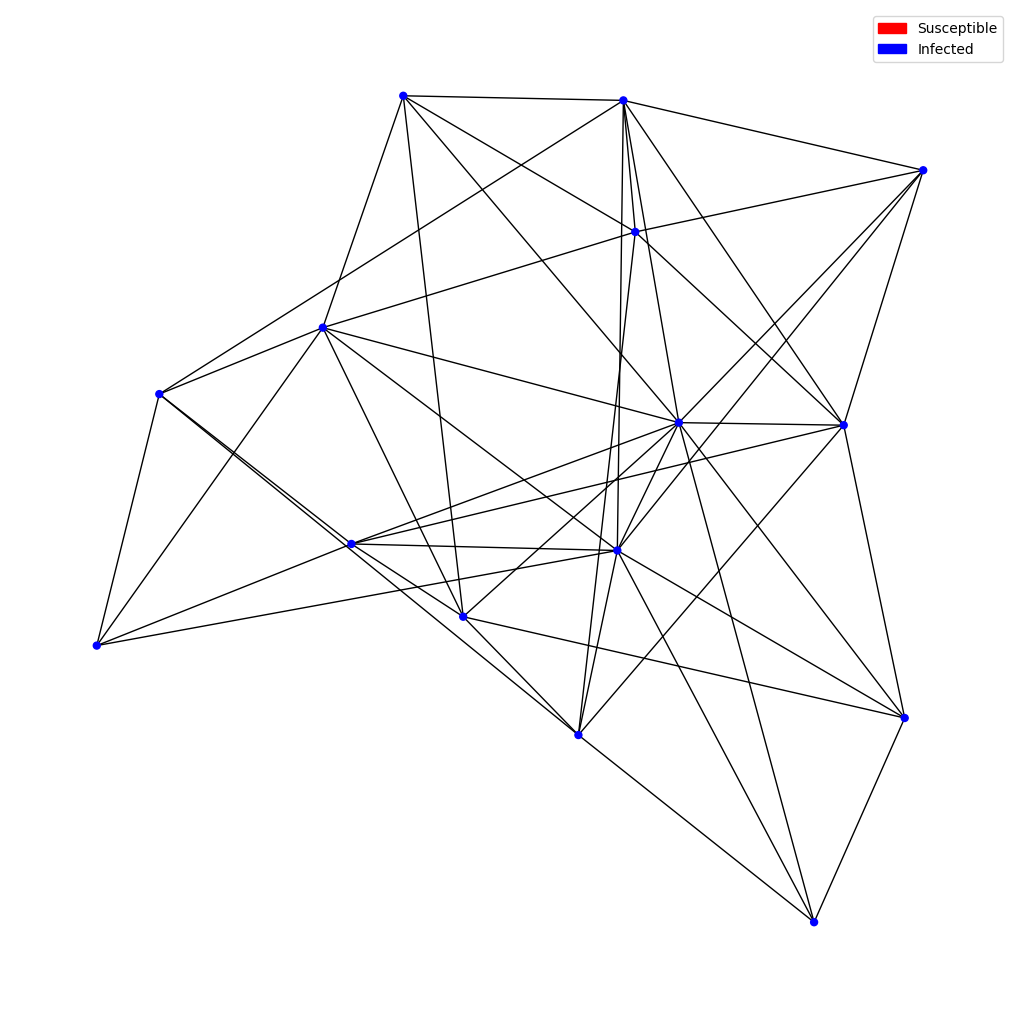

In [7]:
# Visualize the prediction
visualization = epilearn.visualize.plot_graph(prediction[0, -1].argmax(dim=-1).detach().cpu().numpy(), # Get the prediction at the end of the time period ... pick [batch zero, last timestep], most likely class
                                              graph=initial_graph.to_sparse().indices().detach().numpy(), # View the results on the graph
                                              classes=["Susceptible", "Infected"])

## 3 Import and Prepare Custom Dataset

Use COVID-19 time series case data to create a numpy array of shape (num_timesteps, num_nodes(countries), num_features(S or I))

### 3.1 Define URLs for CSV Datasets

Time series CSV will be used for calculating "infected" relative to the "population" found in the world population CSV

In [8]:
# Define the URL for the COVID-19 confirmed cases (global) time series CSV from https://github.com/CSSEGISandData/COVID-19
time_series_cases_URL = "https://github.com/CSSEGISandData/COVID-19/raw/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

# Define the URL for world population CSV from https://github.com/anay15/Table-Population/tree/main
world_population_URL = "https://github.com/anay15/Table-Population/raw/refs/heads/main/population_by_country_2020.csv"

### 3.2 Define and View DataFrames

In [9]:
# Read and view raw_cases_df
raw_cases_df = pd.read_csv(time_series_cases_URL)

raw_cases_df.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [10]:
# Read and view raw_world_pop_df
raw_world_pop_df = pd.read_csv(world_population_URL)

raw_world_pop_df.head(5)

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1440297825,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1382345085,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331341050,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,274021604,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,221612785,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [11]:
# Check shape (rows x columns) of each
print(f"Cases: {raw_cases_df.shape}")
print(f"Population: {raw_world_pop_df.shape}\n")

print(f"Number of countries recorded in cases CSV: {raw_cases_df.shape[0]}")
print(f"Number of cases recorded in cases CSV: {raw_cases_df.shape[1]}\n")

print(f"Number of countries recorded in population CSV: {raw_world_pop_df.shape[0]}")

Cases: (289, 1147)
Population: (235, 11)

Number of countries recorded in cases CSV: 289
Number of cases recorded in cases CSV: 1147

Number of countries recorded in population CSV: 235


### 3.3 Clean and Align DataFrames

The number of countries in each CSV doesn't match, meaning the extraneous data should be removed

In [12]:
# Drop irrelevant columns from raw_cases_df
cases_df = raw_cases_df.drop(columns=["Province/State", "Lat", "Long"])

# Drop irrelevant columns from raw_cases_df
world_pop_df = raw_world_pop_df.drop(columns=["Yearly Change", "Net Change", "Density (P/Km²)",
                                                  "Land Area (Km²)", "Migrants (net)", "Fert. Rate",
                                                  "Med. Age", "Urban Pop %", "World Share"])

In [13]:
# Ensure world_pop_df "country" column matches cases_df
world_pop_df = world_pop_df.rename(columns={"Country (or dependency)": "Country/Region"})

In [14]:
cases_df.head(1)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451


In [15]:
world_pop_df.head(1)

,Country/Region,Population (2020)
0,China,1440297825


In [16]:
# Remove duplicate countries
cases_df = cases_df.drop_duplicates(subset=["Country/Region"])

world_pop_df = world_pop_df.drop_duplicates(subset=["Country/Region"])

cases_df.shape[0], world_pop_df.shape[0]

(201, 235)

In [17]:
# Merge DataFrames into temporary DataFrame using "inner join" to remove non-matching countries
merged_df = pd.merge(cases_df, world_pop_df, how="inner", on="Country/Region")

print(f"Number of countries recorded in population CSV: {raw_world_pop_df.shape[0]}")
print(f"Number of countries recorded in merged DataFrame: {merged_df.shape[0]}")

Number of countries recorded in population CSV: 235
Number of countries recorded in merged DataFrame: 182


In [18]:
merged_df.head(5)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23,Population (2020)
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,209340,209358,209362,209369,209390,209406,209436,209451,209451,39074280
1,Albania,0,0,0,0,0,0,0,0,0,...,334408,334408,334427,334427,334427,334427,334427,334443,334457,2877239
2,Algeria,0,0,0,0,0,0,0,0,0,...,271448,271463,271469,271469,271477,271477,271490,271494,271496,43984569
3,Andorra,0,0,0,0,0,0,0,0,0,...,47875,47875,47875,47875,47875,47875,47875,47890,47890,77287
4,Angola,0,0,0,0,0,0,0,0,0,...,105277,105277,105277,105277,105277,105277,105277,105288,105288,33032075


In [19]:
# Unmerge DataFrames now that they are aligned, keeping only mandatory data (i.e., don't retain country names)
cases_df = merged_df.copy()
cases_df = cases_df.drop(columns=["Country/Region", "Population (2020)"])

world_pop_df = merged_df[["Population (2020)"]].copy()

In [20]:
cases_df.head(1)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451


In [21]:
world_pop_df.head(1)

,Population (2020)
0,39074280


In [22]:
cases_df.shape, world_pop_df.shape

((182, 1143), (182, 1))

### 3.4 Load DataFrame Data into Tensor

Create tensor of shape `(num_countries, num_channels)` where the channels are `[S, I]`

The values of "S" and "I" will be fractions of the local population - any value between 0 and 1

To get the fraction of the population:

* `S = (population - infected cases) / population`
* `I = infected cases / population`

In [23]:
# Get population fractions
cases = cases_df.to_numpy()
population = world_pop_df.to_numpy()

susceptible_frac = np.zeros((cases.T.shape))
infected_frac = np.zeros((population.T.shape))

susceptible_frac.shape, infected_frac.shape

((1143, 182), (1, 182))

In [24]:
susceptible_frac = (population - cases) / population
susceptible_frac = susceptible_frac.T

infected_frac = cases / population
infected_frac = infected_frac.T

susceptible_frac.shape, infected_frac.shape

((1143, 182), (1143, 182))

In [25]:
# Stack features
data = np.stack([susceptible_frac, infected_frac])
data = data.transpose(1, 2, 0) # (num_samples, num_nodes, num_features)
data.shape

(1143, 182, 2)

In [26]:
# Convert features to tensor
data = torch.tensor(data, dtype=torch.float32)
data.shape

torch.Size([1143, 182, 2])

In [27]:
data

tensor([[[1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         ...,
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00]],

        [[1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         ...,
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00]],

        [[1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         ...,
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00]],

        ...,

        [[9.9464e-01, 5.3599e-03],
         [8.8377e-01, 1.1623e-01],
         [9.9383e-01, 6.1724e-03],
         ...,
         [9.9960e-01, 3.9902e-04],
         [9.8142e-01, 1.8580e-02],
         [9.8227e-01, 1.7727e-02]],

        [[9.9464e-01, 5.3603e-03],
         [8.8376e-01, 1.1624e-01],
         [9.

### 3.5 Load Data Into UniversalDataset

#### 3.5.1 Generate graph from dataset

For the sake of simplicity let's just assume that countries may be connected to each other 25% of the time

A more advanced / realistic technique would be leveraging the latitude and longitude coordinates and having weighted edges among all countries, but that goes beyond the introductory scope of this mini-project

Further, the below graph will include all 182 countries, which makes it rough to visualize ... perhaps only including 15-25 countries would yield a nicer result

In [28]:
NUM_NODES = len(data[0]) # 182
CONNECT_PROB = 0.25

graph = epilearn.utils.simulation.get_random_graph(num_nodes=NUM_NODES,
                                                   connect_prob=CONNECT_PROB)
graph

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

#### 3.5.2 Generate Dataset

In [29]:
dataset = epilearn.data.UniversalDataset(x=data[:-1], # all except last step
                                         y=data[1:]) # all except first step

#### 3.5.3 Test Dataset on Model

In [30]:
# Instantiate model
model = NetSIS(num_nodes=NUM_NODES,
               horizon=500, # Predict next 500 days
               adj=graph.to("cpu"),
               infection_rate=0.40,
               susceptible_rate=0.40)

# Get prediction
prediction = model(data[-1].unsqueeze(0).unsqueeze(1)) # Predict last time step

prediction.shape

torch.Size([1, 500, 182, 2])

In [31]:
prediction.argmax(-1)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])

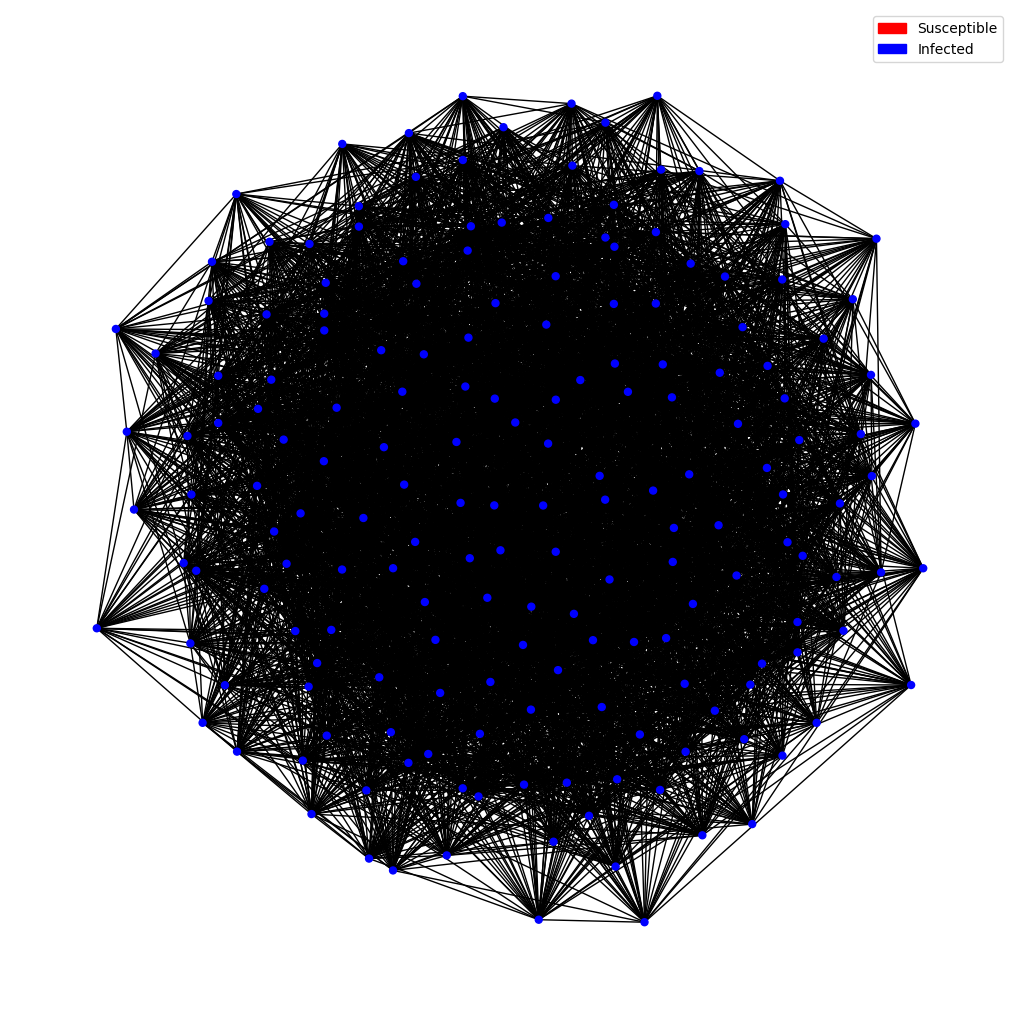

In [32]:
# Visualize the prediction
visualization = epilearn.visualize.plot_graph(prediction[0, -1].argmax(dim=-1).detach().cpu().numpy(),
                                              graph=graph.to_sparse().indices().detach().numpy(),
                                              classes=["Susceptible", "Infected"])

What does the above mean? It means that a country / node is MORE susceptible than infected (or vice versa) given it's visual label

## 4 Initialize EpiLearn Task and Train / Evaluate Model

The prediction done in 3.5.3 was performed by an untrained model ... now it is time to actually train the model based on the dataset that was prepared in 3.5.2

### 4.1 Create and Apply Dataset Transformation

Leverage the transforms.Compose to normalize the features, target, and graph of the dataset

In [33]:
# transformation = epilearn.utils.transforms.Compose({
#     "features": [epilearn.utils.transforms.normalize_feat()],
#     "target": [epilearn.utils.transforms.normalize_feat()],
#     "graph": [epilearn.utils.transforms.normalize_adj()]
# })

# dataset.transforms = transformation

### 4.2 Initialize Task

Define hyperparameters like DEVICE, LOOKBACK, BATCH_SIZE, etc.

Define the task

In [34]:
# Define device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(DEVICE)
DEVICE

device(type='cpu')

In [51]:
# Redefine model and some hyperparameters
LOOKBACK = 60
HORIZON = 20
INFECTION_RATE = 0.4
SUSCEPTIBLE_RATE = 0.3
BATCH_SIZE = 16

In [52]:
task = epilearn.tasks.Forecast(prototype=NetSIS,
                               lookback=LOOKBACK,
                               horizon=HORIZON,
                               device=DEVICE)

### 4.3 Train and Evaluate Model

100%|██████████| 20/20 [00:39<00:00,  1.96s/it]




Final Training loss: 0.007165103105230714
Final Validation loss: 0.045662108808755875


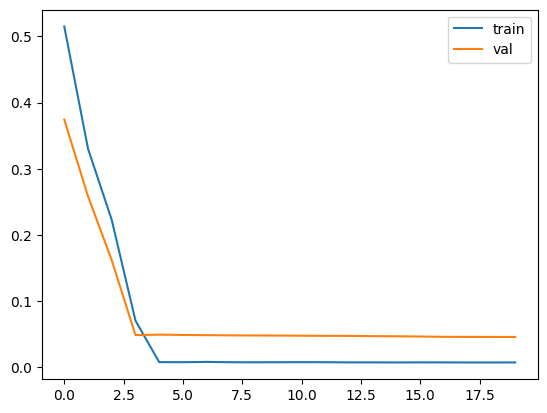

Test MSE: 0.045662108808755875
Test MAE: 0.13450393080711365
Test RMSE: 0.21368694305419922


In [53]:
train_results = task.train_model(dataset=dataset,
                                 model_args={
                                     "num_nodes": NUM_NODES,
                                     "horizon": HORIZON,
                                     "adj": graph.to("cpu"),
                                     "infection_rate": INFECTION_RATE,
                                     "susceptible_rate": SUSCEPTIBLE_RATE
                                     },
                                 train_rate=0.8,
                                 val_rate=0.2,
                                 epochs=20,
                                 weight_decay=1e-4,
                                 lr=0.01,
                                 device=DEVICE,
                                 batch_size=BATCH_SIZE)

In [38]:
evaluation = task.evaluate_model()

Test MSE: 0.04492124915122986
Test MAE: 0.12852244079113007
Test RMSE: 0.21194633841514587


### 4.4 Inference Model

Access the task's validation split of the dataset and inference the model to make a prediction on it

In [39]:
# Get the validation split from the task's dataset
data = task.val_dataset
data

{'features': tensor([[[9.9528e-01, 4.7211e-03],
          [8.9437e-01, 1.0563e-01],
          [9.9393e-01, 6.0651e-03],
          ...,
          [9.9960e-01, 3.9582e-04],
          [9.8221e-01, 1.7790e-02],
          [9.8280e-01, 1.7198e-02]],
 
         [[9.9528e-01, 4.7240e-03],
          [8.9403e-01, 1.0597e-01],
          [9.9393e-01, 6.0667e-03],
          ...,
          [9.9960e-01, 3.9582e-04],
          [9.8221e-01, 1.7790e-02],
          [9.8280e-01, 1.7199e-02]],
 
         [[9.9527e-01, 4.7299e-03],
          [8.9395e-01, 1.0605e-01],
          [9.9393e-01, 6.0684e-03],
          ...,
          [9.9960e-01, 3.9582e-04],
          [9.8216e-01, 1.7841e-02],
          [9.8280e-01, 1.7200e-02]],
 
         ...,
 
         [[9.9464e-01, 5.3592e-03],
          [8.8377e-01, 1.1623e-01],
          [9.9383e-01, 6.1721e-03],
          ...,
          [9.9960e-01, 3.9902e-04],
          [9.8142e-01, 1.8580e-02],
          [9.8227e-01, 1.7727e-02]],
 
         [[9.9464e-01, 5.3599e-03],


In [40]:
prediction = task.model(x=data['features'].unsqueeze(0),
                        graph=graph)
prediction.shape

torch.Size([1, 20, 182, 2])

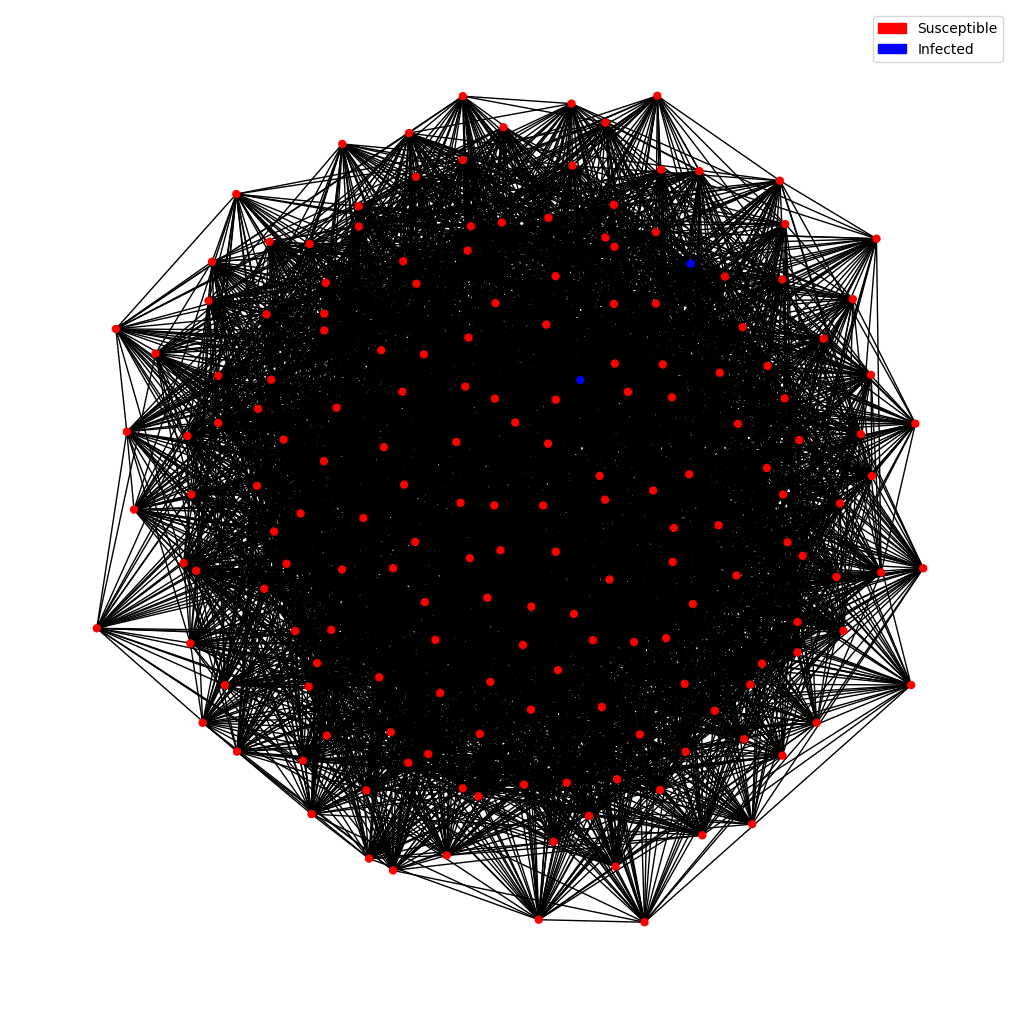

In [41]:
visualization = epilearn.visualize.plot_graph(states=prediction[0, -1].argmax(dim=-1).detach().cpu().numpy(),
                                              graph=graph.to_sparse().indices().detach().numpy(),
                                              classes=["Susceptible", "Infected"])